In [1]:
from libraries import lib
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy.random as npr
import random

class SparseStateVector:
    """
    Container class for dictionary (self.values) with keys of integer states
    and values being complex amplitude of psi
    """
    def __init__(self):
        self.values = {}
        self.normalized = False

    def TFIM_multiply(psi, N, J, Gamma):
        """
        Returns new sparse vector representing H|psi>
        """
        prod = SparseStateVector()
        for state in psi.values:
            jtotal = 0
            for site in range(N - 1):
                jtotal += J if ((state >> site) ^ (state >> site + 1)) & 1 else -J
            jtotal += J if ((state >> (N - 1)) ^ (state >> 0)) & 1 else -J 
            prod.values[state] = jtotal * psi.values[state]
        
        for state in psi.values:
            for site in range(N):
                flipped_state = state ^ (1 << site)
                prod.values[flipped_state] = prod.values.get(flipped_state, 0) - Gamma * psi.values[state]
        return prod

    def inner_product(v1, v2):
        """
        Returns <v1|v2> for two SparseStateVectors
        """
        prod = 0
        for s in v1.values:
            if s in v2.values:
                prod += torch.conj(v1.values[s]) * v2.values[s]
        return prod

    def TFIM_expectation_from_sparse(psi, N, J, Gamma):
        """
        Returns <psi|H|psi>/<psi|psi> for SparseStateVector psi
        """
        # do H|psi> then <psi| (H|psi>)
        hpsi = SparseStateVector.TFIM_multiply(psi, N, J, Gamma)
        exp = SparseStateVector.inner_product(psi, hpsi)
        if not psi.normalized:
            mag2 = SparseStateVector.inner_product(psi, psi)
            return (exp / mag2).real
        return exp.real

    def normalize(self):
        """
        Normalizes values
        """
        mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
        for s in self.values:
            self.values[s] = self.values[s] / mag
        self.normalized = True

    def to_prob_distribution(self, N):
        """
        Returns 1D list representing real probability distribution
        """
        if not self.normalized:
            mag2 = sum(abs(self.values[s]) ** 2 for s in self.values)
            return [(abs(self.values.get(s, 0)) ** 2 / mag2).item() for s in range(0, 2 ** N)]
        return [abs(self.values.get(s, 0)) ** 2 for s in range(0, 2 ** N)]
    
    def to_dense_vector(self, N):
        """
        Returns 1D list of dense representation
        """
        if not self.normalized:
            mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
            return [(self.values.get(s, 0) / mag).item() for s in range(0, 2 ** N)]
        return [self.values.get(s, 0).item() for s in range(0, 2 ** N)]

class UniformNeuralState(SparseStateVector):
    def __init__(self, N, model, output_to_psi, num_samples, informed = False):
        """
        Initializes sparse vector values

        Args:
            N (int): number of qubits
            model: torch model representing psi(x), which returns complex amplitude given integer state
            output_to_psi (function): takes in output of model to compute complex amplitude
            num_samples (int): number of unique integer samples to take
            informed (bool): whether to guarantee sample first and last states
        """
        super().__init__()
        self.samples = num_samples
        self.distribution = {}
        self.list = []
        self.nn_output = {}
        def psi(x):
            tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
            nn_output = model(tens)
            return output_to_psi(nn_output)[0], nn_output[0]
        if num_samples >= 2 ** N:
            for state in range(2 ** N):
                self.distribution[state] = 1
                self.list.append(state)
                self.values[state], self.nn_output[state] = psi(state)
        else:
            sampled_states = set()
            if informed: 
                sampled_states.add(0)
                self.distribution[0] = self.distribution.get(0, 0) + 1
                self.list.append(0)
                sampled_states.add(2 ** N - 1)
                self.distribution[2 ** N - 1] = self.distribution.get(2 ** N - 1, 0) + 1
                self.list.append(2 ** N - 1)
                num_samples = num_samples - 2
            for _ in range(num_samples):
                x = random.getrandbits(N)
                while x in sampled_states:
                    x = random.getrandbits(N)
                sampled_states.add(x)
                self.distribution[x] = self.distribution.get(x, 0) + 1
                self.list.append(x)
            for state in sampled_states:
                self.values[state], self.nn_output[state] = psi(state)

class MHNeuralState(SparseStateVector):
    def __init__(self, N, model, output_to_psi, x_func, x0, num_samples, burnin = 0, lag = 0, informed = False):
        """
        Initializes distribution of samples and vector values

        Args:
            N (int): number of qubits
            model: torch model representing psi(x), which returns complex amplitude given integer state
            output_to_psi (function): takes in output of model to compute complex amplitude
            x_func (function): takes in state x and generates proposal x*
            x0 (int): intger state to begin sampling
            num_samples (int): number of proposal x* generated
            burnin (int): number of samples to throw away before accepting first sample
            lag (int): number of samples to throw away in-between accepting samples
            informed (bool): whether to guarantee sample first and last states
        """
        # uses arbitrary x_func for MH sampling
        super().__init__()
        self.distribution = {}
        self.list = []
        self.nn_output = {}
        self.samples = num_samples
        def psi(x):
            tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
            nn_output = model(tens)
            return output_to_psi(nn_output)[0], nn_output[0]
        num_uniform = burnin + num_samples * (lag + 1)
        rand_uniform = npr.uniform(0, 1, num_uniform)
        index = 0
        if informed: 
            self.values[0], self.nn_output[0] = psi(0)
            self.values[2 ** N - 1], self.nn_output = psi(2 ** N - 1)
            self.distribution[0] = 1
            self.list.append(0)
            self.distribution[2 ** N - 1] = 1
            self.list.append(2 ** N - 1)
            num_samples = num_samples - 2
        x = x0
        psi_val, nn_val = psi(x)
        self.values[x] = psi_val
        self.nn_output[x] = nn_val
        for _ in range(burnin):
            new_x = x_func(x)
            new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
            ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
            if ratio > 1 or ratio > rand_uniform[index]:
                x = new_x
                psi_val = new_psi_val
            index += 1
        for _ in range(num_samples):
            for _ in range(lag):
                new_x = x_func(x)
                new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
                ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
                if ratio > 1 or ratio > rand_uniform[index]:
                    x = new_x
                    psi_val = new_psi_val
                index += 1
            new_x = x_func(x)
            if new_x in self.values: new_psi_val, new_nn_val = self.values[new_x], self.nn_output[new_x]
            else: new_psi_val, new_nn_val = psi(new_x)
            ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
            if ratio > 1 or ratio > rand_uniform[index]:
                self.distribution[new_x] = self.distribution.get(new_x, 0) + 1
                self.list.append(new_x)
                x = new_x 
                psi_val = new_psi_val 
            else: 
                self.distribution[x] = self.distribution.get(x, 0) + 1
                self.list.append(x)
            self.values[new_x] = new_psi_val
            self.nn_output[new_x] = new_nn_val
            index += 1

    # def distribution_to_list(self):
    #     """
    #     Returns list of sampled states with repetition
    #     """
    #     return [state for state in self.distribution for _ in range(self.distribution[state])]

In [3]:
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * 2 * np.pi * nn_output[:, 1])
c = 1e-8
def log_amp_phase_c(nn_output):
    return (torch.exp(nn_output[:, 0]) - c) * torch.exp(1.j * 2 * np.pi * nn_output[:, 1]) 
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [4]:
# only for nn_output = (log(amp), phase)
def generate_eloc_list(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    res = 0
    total_amp = 0
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output

    eloc_values = []
    for basis_state in sampled_vector.list:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            # eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * (torch.exp(output_prime[0]) - c) / (torch.exp(output[0]) - c) * torch.exp(1.j * 2 * np.pi * (output_prime[1] - output[1]))
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        eloc += lib.calc_H_elem(N, J, Gamma, basis_state, basis_state)
        # state_amp = abs(sampled_vector.values[basis_state]) ** 2
        # total_amp += state_amp
        # res += state_amp * eloc
        eloc_values.append(eloc)
        # for _ in range(sampled_vector.distribution[basis_state]):
        #     eloc_values.append(eloc)
    return eloc_values
    # return (res / total_amp).real

In [5]:
N = 30; J = 1
num_epochs = 100 + 1
data_rate = 1
num_samples = 500

In [6]:
Gamma = 10
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.SiLU(),
    nn.Linear(5 * N, 2),
    nn.SiLU(),
) 
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-299.2767+0.4977j) 1.4519869089126587
1 tensor(-291.6730-1.8399j) 8.370169639587402
2 tensor(-300.9193+0.j) 0.06346623599529266
3 tensor(-300.3441+0.j) 0.0020793394651263952
4 tensor(-301.1913+0.j) 0.0033637811429798603
5 tensor(-300.7080+0.j) 0.0006214961176738143
6 tensor(-300.8060+0.j) 0.0022639259696006775
7 tensor(-300.1762+0.j) 6.465327169280499e-05
8 tensor(-299.8175+0.j) 0.0002896508958656341
9 tensor(-301.6480+0.j) 2.4117920474964194e-05
10 tensor(-300.5679+0.j) 1.0745367944764439e-05
11 tensor(-299.7359+0.j) 6.849522378615802e-06
12 tensor(-299.9453+0.j) 0.0002278465690324083
13 tensor(-299.4402+0.j) 7.810588431311771e-05
14 tensor(-299.9786+0.j) 0.0005133074009791017
15 tensor(-300.9521+0.j) 6.478965951828286e-05
16 tensor(-300.6719+0.j) 1.0896280400629621e-05
17 tensor(-301.5039+0.j) 0.00013158317597117275
18 tensor(-301.2079+0.j) 3.492936593829654e-05
19 tensor(-299.5599+0.j) 6.200623829499818e-06
20 tensor(-300.2646+0.j) 0.0001274145906791091
21 tensor(-300.7519+

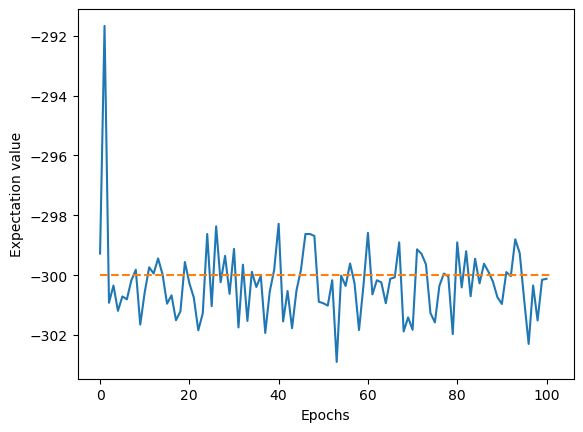

In [7]:
# ground state energy about -10N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-10 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [8]:
Gamma = 0.1
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.LogSigmoid(),
    nn.Linear(5 * N, 2),
    nn.LogSigmoid()
) 
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-1.2560+0.0214j) 0.027623428031802177
1 tensor(-3.4182-0.0034j) 0.07671526074409485
2 tensor(-3.3817+0.0038j) 0.0011801925720646977
3 tensor(-4.3263+0.0114j) -0.007816880941390991
4 tensor(-1.3347-0.0037j) 0.007612086366862059
5 tensor(-3.5028-0.0012j) -0.0038154511712491512
6 tensor(-3.0791-0.0014j) 0.004644325003027916
7 tensor(-2.9506+0.0029j) -0.007451038341969252
8 tensor(-2.5108+0.0021j) 0.00820184126496315
9 tensor(-2.5602-0.0005j) -0.007586903404444456
10 tensor(-4.2000-0.0011j) 0.010386531241238117
11 tensor(-2.7913-0.0018j) -0.013322122395038605
12 tensor(-3.9912+0.0028j) 0.003018023446202278
13 tensor(-4.5598-0.0022j) 0.0007225712179206312
14 tensor(-1.3734+0.0017j) -0.01907219924032688
15 tensor(-3.4422-0.0028j) -0.17537613213062286
16 tensor(-4.2590+0.0022j) -0.31277209520339966
17 tensor(-8.2101-0.0031j) -1.037108302116394
18 tensor(-9.3148-0.0020j) -0.40797093510627747
19 tensor(-15.8887-0.0011j) 2.0522990226745605
20 tensor(-14.4124+0.0003j) -7.530480861663818


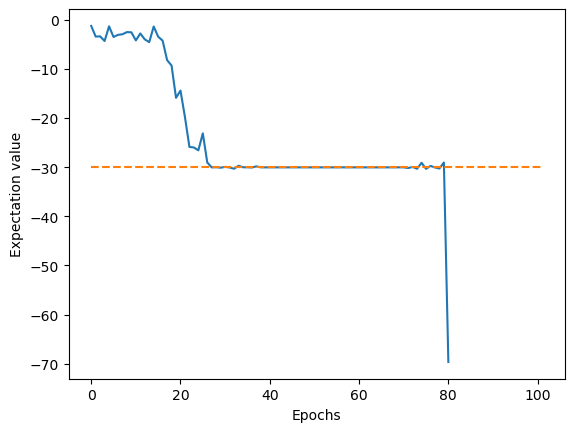

In [9]:
# ground state energy about -N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [ ]:
Gamma = 1
num_samples = 1000
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.SiLU(),
    nn.Linear(5 * N, 2),
    nn.SiLU(),
)
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-30.4294+0.2002j) 0.129915252327919
1 tensor(-29.2620-0.1273j) 0.3530515134334564
2 tensor(-30.5598+0.0059j) -0.029958227649331093
3 tensor(-29.3624+0.0051j) -0.014660852961242199
4 tensor(-29.9278+0.0291j) -0.10988564044237137
5 tensor(-30.3022+0.0164j) 0.6414369940757751
6 tensor(-30.2241+0.0151j) -0.03610801324248314
7 tensor(-29.5585-0.0018j) -0.04768417403101921
8 tensor(-30.1997-0.0002j) 0.09863121807575226
9 tensor(-30.3132+0.0190j) 0.014483227394521236
10 tensor(-31.3193-0.0034j) -0.07906091958284378
11 tensor(-30.0539-0.0011j) -0.11919830739498138
12 tensor(-29.9006-0.0064j) -0.030395815148949623
13 tensor(-29.7365+0.0237j) 0.08958058059215546
14 tensor(-30.3499+0.0077j) -0.08708078414201736
15 tensor(-29.7815+0.0176j) -0.24029605090618134
16 tensor(-29.9789-0.0023j) -0.31930774450302124
17 tensor(-30.2848+0.0411j) 0.04447568953037262
18 tensor(-30.0849-0.0022j) 0.0265022125095129
19 tensor(-29.7071-0.0413j) 1.8175990581512451
20 tensor(-30.3625-0.0901j) 0.21710956096

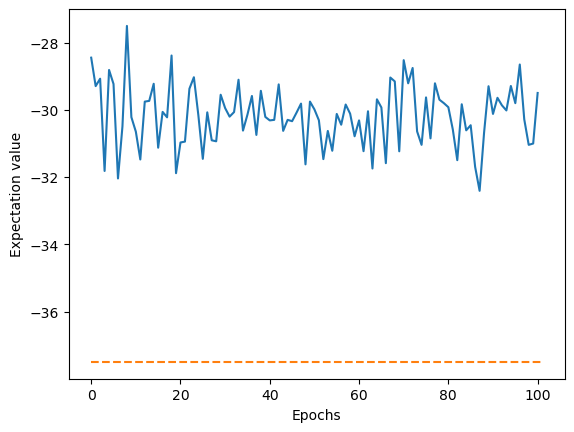

In [11]:
# ground state energy about -1.25 * N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-1.25 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()